In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Unzip DataSet
!unzip gdrive/My\ Drive/frauddetect.zip

Archive:  gdrive/My Drive/frauddetect.zip
  inflating: creditcard.csv          


In [3]:
# Imported Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn as sk
import seaborn as sns
import tensorflow as tf
import matplotlib.patches as mpatches
from pylab import rcParams
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import mean_squared_error,classification_report,make_scorer,accuracy_score,plot_roc_curve,auc,roc_curve
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
import cufflinks as cf
import warnings
warnings.filterwarnings("ignore")
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


In [4]:
#Read the data
data= pd.read_csv("creditcard.csv")

In [5]:
#Verify the dataframe 
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#check the describe of the dataset
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
#Check Null Values
data.isnull().sum().max()

0

In [8]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
#Check for duplicates
data[data.duplicated()].shape

(1081, 31)

In [10]:
#Drop the duplicate data !
data = data[~data.duplicated()]

In [11]:
#Check for duplicate data again
data[data.duplicated()].shape


(0, 31)

In [12]:
#check normal&fraud transecton
normal = data.loc[data['Class'] == 0]
fraud = data.loc[data['Class'] == 1]
print('Normal: ', normal)
print('Frauds:', fraud)

Normal:              Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[283253 rows x 31 columns]
Frauds:             Time        V1        V2  ...       V28  Amount  Class
541        406.0 -2.312227  1.951992  ... -0.143276    0.00 

In [ ]:
print('Normal:', len(normal) )
print('Fraud:', len(fraud) )

Normal: 283253
Fraud: 473


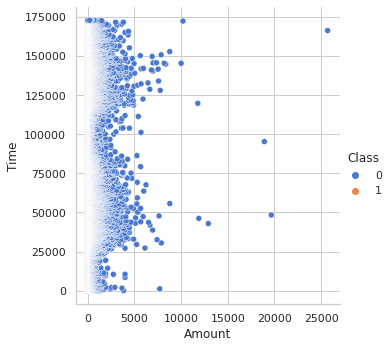

In [24]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 21, 12
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
sns.relplot(x="Amount", y="Time",hue="Class", data=data)

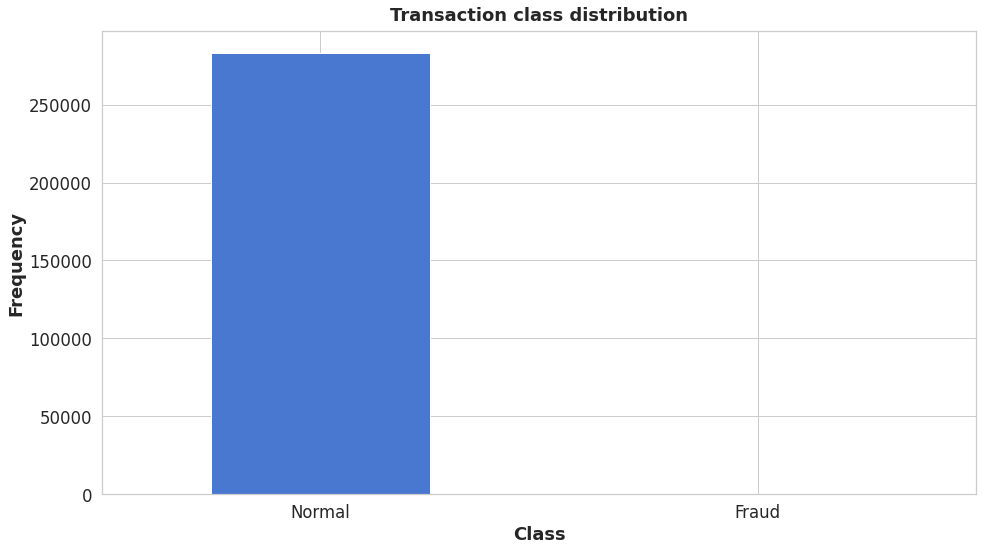

In [ ]:
#Fraud column analysis
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [15]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1) 

,Amount,Amount
count,473.000000,283253.000000
mean,123.871860,88.413575
std,260.211041,250.379023
min,0.000000,0.000000
25%,1.000000,5.670000
50%,9.820000,22.000000
75%,105.890000,77.460000
max,2125.870000,25691.160000


In [ ]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)


,Time,Time
count,473.000000,283253.000000
mean,80450.513742,94835.058093
std,48636.179973,47475.550607
min,406.000000,0.000000
25%,41203.000000,54233.000000
50%,73408.000000,84711.000000
75%,129095.000000,139308.000000
max,170348.000000,172792.000000


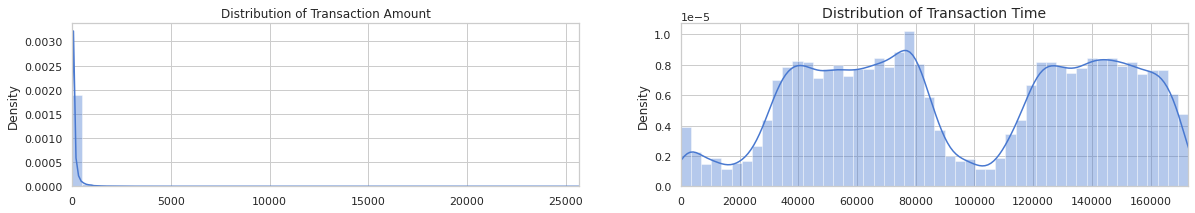

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(20,3))
amount_val = data['Amount'].values
time_val = data['Time'].values
sns.distplot(amount_val, ax=ax[0])#, color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=12)
ax[0].set_xlim([min(amount_val), max(amount_val)])
sns.distplot(time_val, ax=ax[1])#, color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()

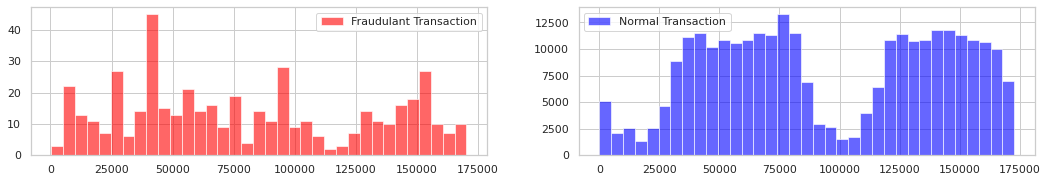

In [66]:
plt.figure(figsize=(18, 6))
plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='red', alpha=0.6, label="Fraudulant Transaction")
plt.legend()
plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Normal Transaction")
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15cad646d0>,
      dtype=object)

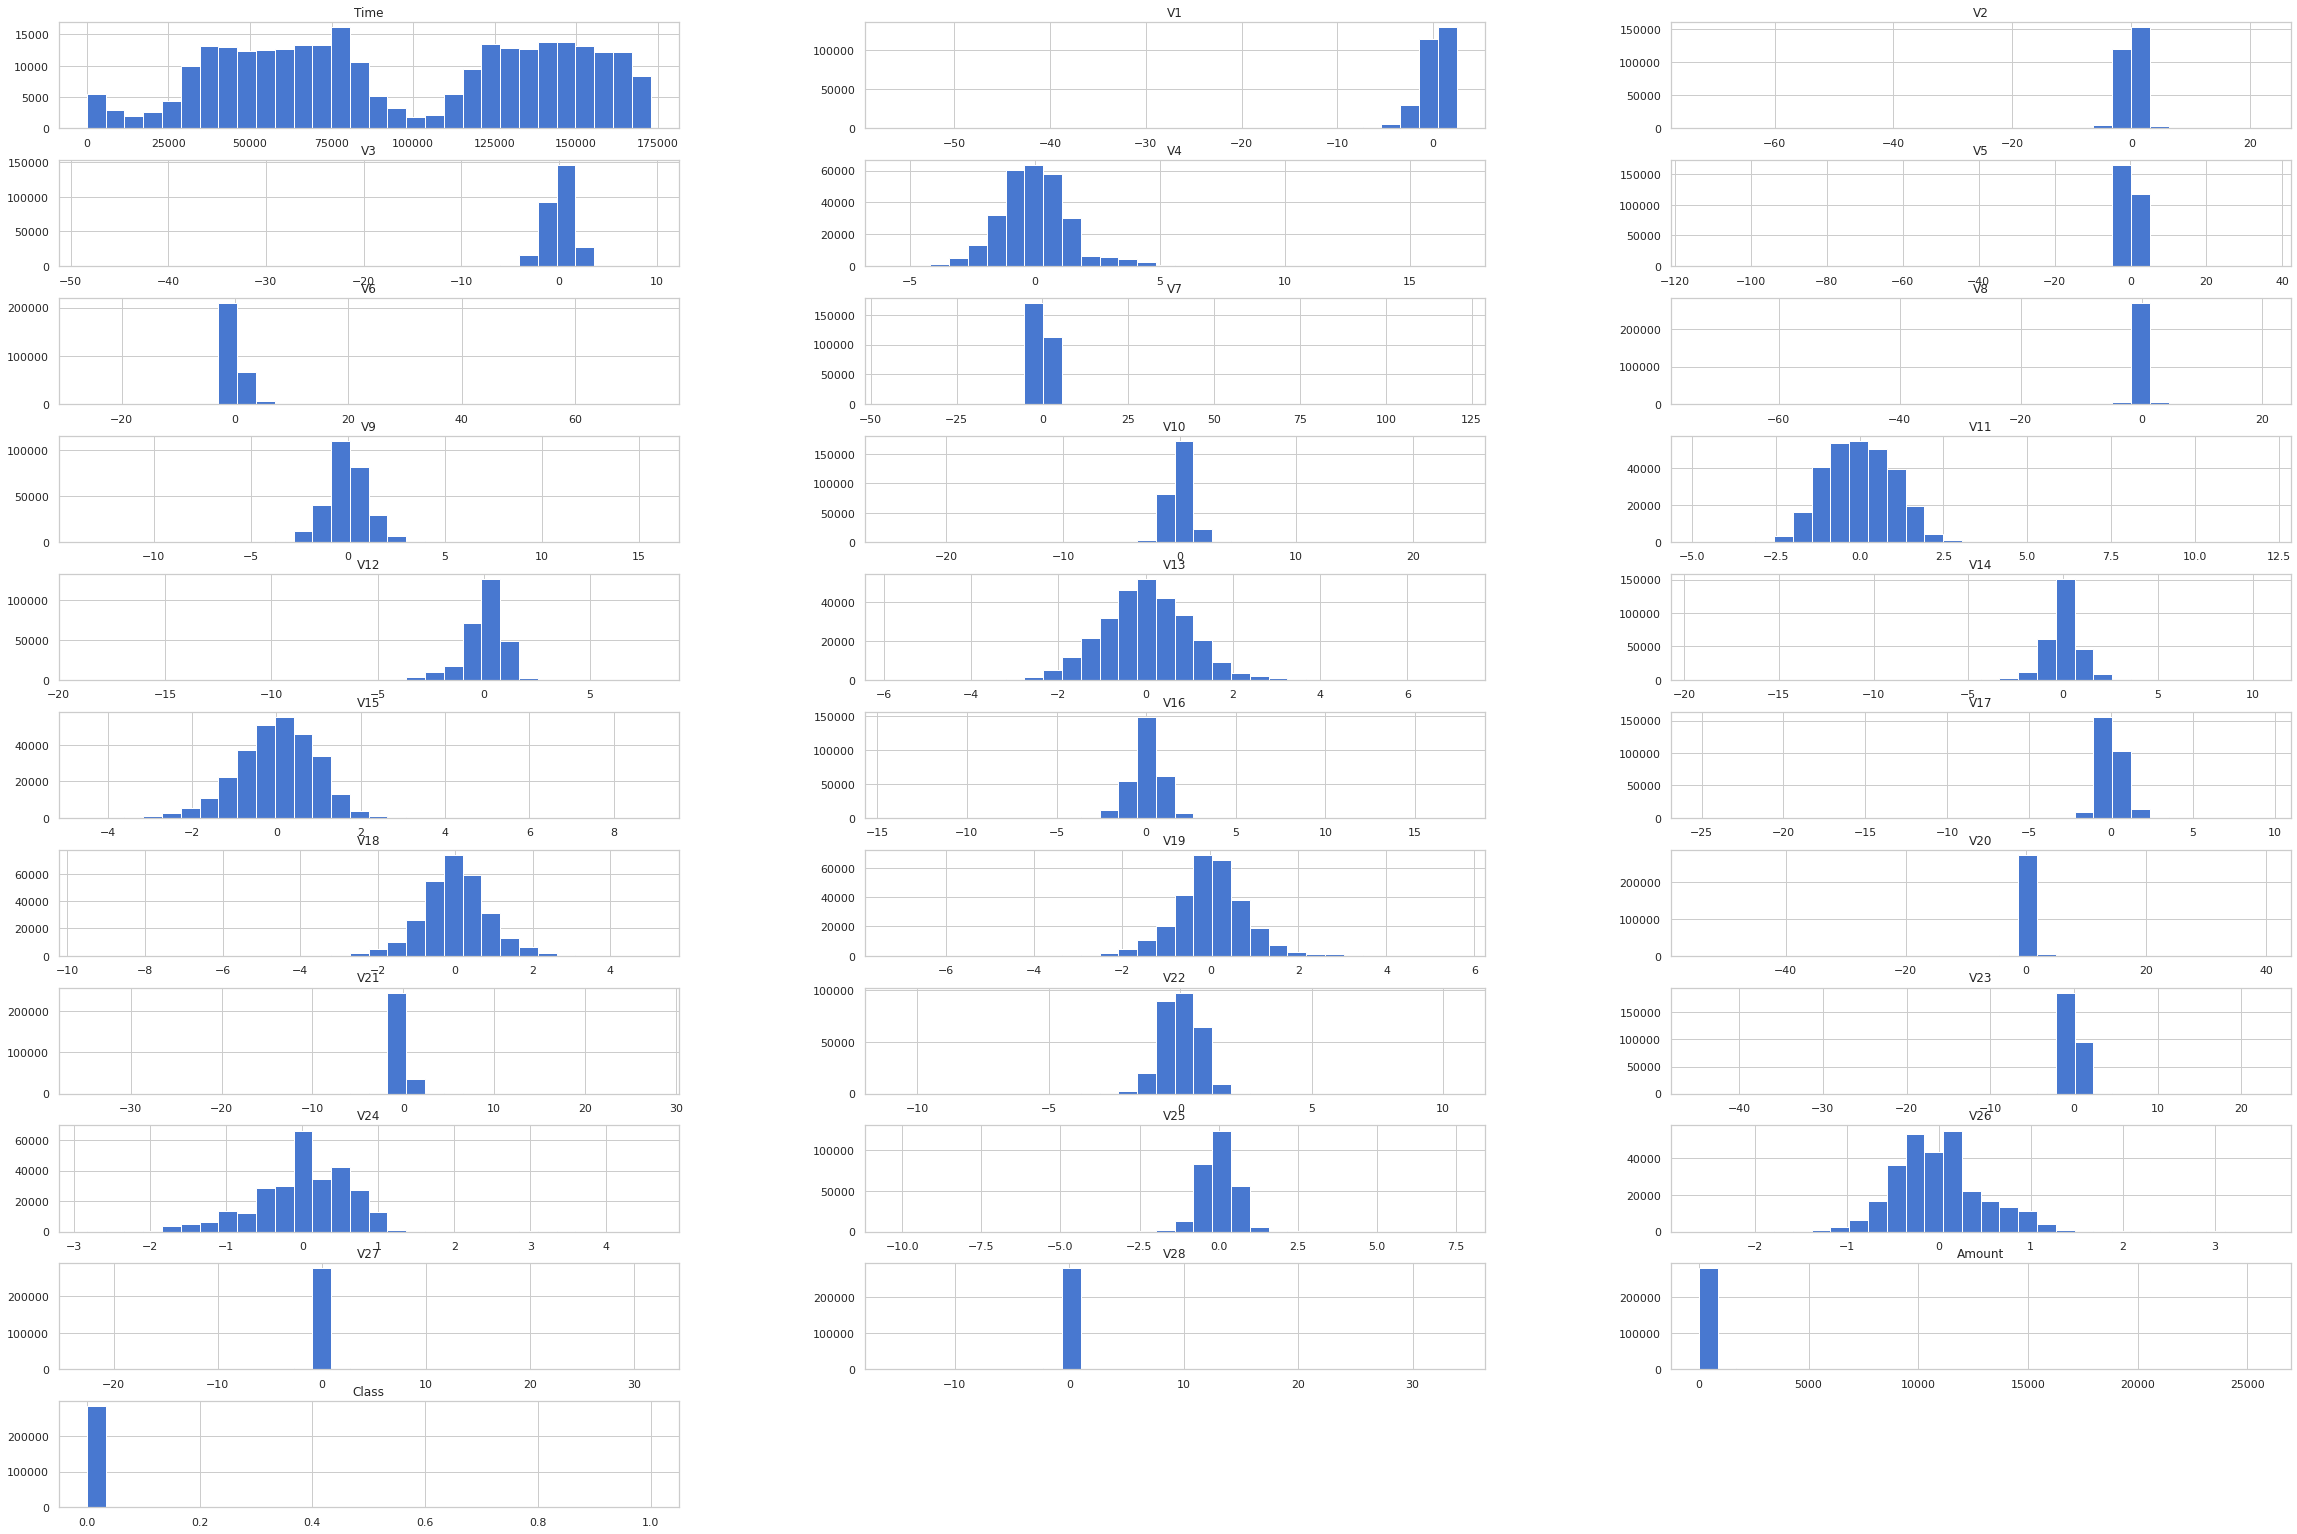

In [58]:
data.hist(figsize=(40,40),layout=(16,3),bins=30)

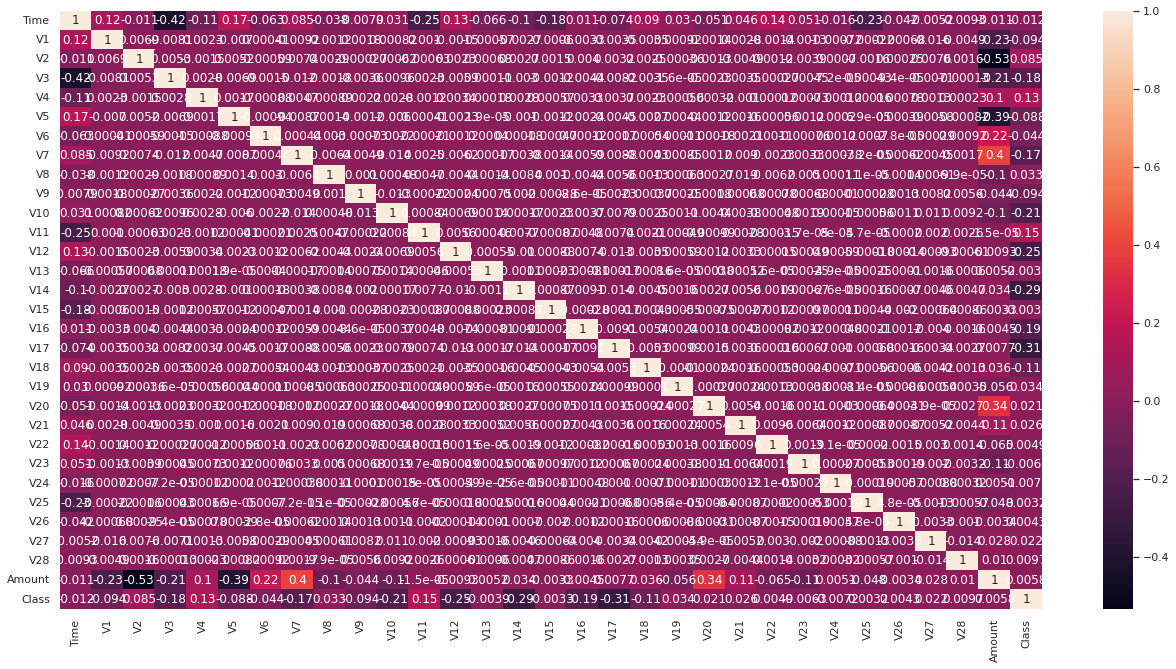

In [69]:
plt.figure(figsize=(22,11))
sns.heatmap(data.corr(), annot=True)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
scalar = StandardScaler()
X = data.drop('Class', axis=1)
y = data.Class

In [29]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [30]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 283726, dtype: int64

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

In [83]:
ft = y_train.value_counts()[0] / len(y_train)
nt = y_train.value_counts()[1] / len(y_train)

In [84]:
print(f"Fraud transaction: {ft} " , 
       f"Normal transaction: {nt}  " )

Fraud transaction: 0.9982983082209886  Normal transaction: 0.0017016917790113667  


In [85]:
print( f"Training:  {X_train.shape},  {y_train.shape}\n){''*55}"
      f"Validation:  {X_validate.shape}, {y_validate.shape}\n{''*50}"
      f"Testing: {X_test.shape}, {y_test.shape}")

Training:  (181584, 30),  (181584,)
)Validation:  (45396, 30), (45396,)
Testing: (56746, 30), (56746,)


In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n" , f"Accuracy Score: {accuracy_score(label, prediction)}")
        print(f"Classification Report:\n {clf_report}" , f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n" , f"Accuracy Score: {accuracy_score(label, prediction)}\n" , 
              f"Classification Report:\n{clf_report}\n",
              f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n" ) 

In [55]:
#ANNS ALGORITHEM
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               7936      
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [52]:
METRICS = [
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]
class_weight = {0:ft, 1:nt}

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=300, 
#     class_weight=class_weight,
    callbacks=callbacks,
)

Epoch 1/300
89/89 [==============================] - 10s 86ms/step - loss: 0.4466 - fn: 65.0000 - fp: 28731.0000 - tn: 152544.0000 - tp: 244.0000 - precision: 0.0084 - recall: 0.7896 - val_loss: 0.1330 - val_fn: 12.0000 - val_fp: 16.0000 - val_tn: 45306.0000 - val_tp: 62.0000 - val_precision: 0.7949 - val_recall: 0.8378
Epoch 2/300
89/89 [==============================] - 7s 79ms/step - loss: 0.0788 - fn: 99.0000 - fp: 451.0000 - tn: 180824.0000 - tp: 210.0000 - precision: 0.3177 - recall: 0.6796 - val_loss: 0.0291 - val_fn: 17.0000 - val_fp: 13.0000 - val_tn: 45309.0000 - val_tp: 57.0000 - val_precision: 0.8143 - val_recall: 0.7703
Epoch 3/300
89/89 [==============================] - 7s 78ms/step - loss: 0.0287 - fn: 110.0000 - fp: 146.0000 - tn: 181129.0000 - tp: 199.0000 - precision: 0.5768 - recall: 0.6440 - val_loss: 0.0175 - val_fn: 12.0000 - val_fp: 16.0000 - val_tn: 45306.0000 - val_tp: 62.0000 - val_precision: 0.7949 - val_recall: 0.8378
Epoch 4/300
89/89 [====================

In [53]:
score = model.evaluate(X_test, y_test)
print(score)

1774/1774 [==============================] - 3s 2ms/step - loss: 0.0079 - fn: 29.0000 - fp: 4.0000 - tn: 56652.0000 - tp: 61.0000 - precision: 0.9385 - recall: 0.6778
[0.007925789803266525, 29.0, 4.0, 56652.0, 61.0, 0.9384615421295166, 0.6777777671813965]


Train Result:
 Accuracy Score: 0.07904881487355714
Classification Report:
                        0           1  accuracy      macro avg   weighted avg
precision       0.999573    0.001809  0.079049       0.500691       0.997875
recall          0.077512    0.980583  0.079049       0.529047       0.079049
f1-score        0.143868    0.003611  0.079049       0.073739       0.143629
support    181275.000000  309.000000  0.079049  181584.000000  181584.000000 Confusion Matrix: 
 [[ 14051 167224]
 [     6    303]]

Test Result:
 Accuracy Score: 0.07679836464244176
 Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999766   0.001696  0.076798      0.500731      0.998183
recall         0.075349   0.988889  0.076798      0.532119      0.076798
f1-score       0.140137   0.003386  0.076798      0.071762      0.139920
support    56656.000000  90.000000  0.076798  56746.000000  56746.000000
 Confusion Matrix: 
 [[ 4269 52387]
 [    1  

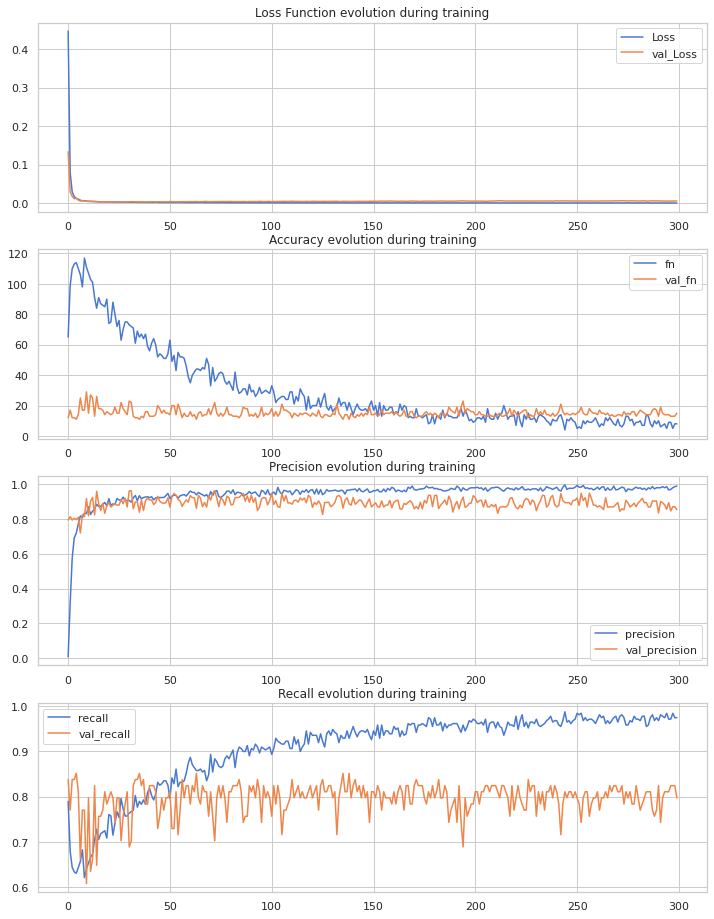

In [92]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 1, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()
#
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

In [93]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_train_pred = lgbm_clf.predict(X_train)
y_test_pred = lgbm_clf.predict(X_test)
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
 Accuracy Score: 0.996365318530267
Classification Report:
                        0           1  accuracy      macro avg   weighted avg
precision       0.999121    0.230415  0.996365       0.614768       0.997813
recall          0.997236    0.485437  0.996365       0.741337       0.996365
f1-score        0.998178    0.312500  0.996365       0.655339       0.997011
support    181275.000000  309.000000  0.996365  181584.000000  181584.000000 Confusion Matrix: 
 [[180774    501]
 [   159    150]]

Test Result:
 Accuracy Score: 0.9956648926796602
 Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999115   0.169492  0.995665      0.584303      0.997799
recall         0.996541   0.444444  0.995665      0.720492      0.995665
f1-score       0.997826   0.245399  0.995665      0.621612      0.996633
support    56656.000000  90.000000  0.995665  56746.000000  56746.000000
 Confusion Matrix: 
 [[56460   196]
 [   50    4

In [94]:
#Random Forest RF
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, oob_score=False)
rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
 Accuracy Score: 1.0
Classification Report:
                   0      1  accuracy  macro avg  weighted avg
precision       1.0    1.0       1.0        1.0           1.0
recall          1.0    1.0       1.0        1.0           1.0
f1-score        1.0    1.0       1.0        1.0           1.0
support    181275.0  309.0       1.0   181584.0      181584.0 Confusion Matrix: 
 [[181275      0]
 [     0    309]]

Test Result:
 Accuracy Score: 0.9994713283755683
 Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999506   0.968750  0.999471      0.984128      0.999457
recall         0.999965   0.688889  0.999471      0.844427      0.999471
f1-score       0.999735   0.805195  0.999471      0.902465      0.999427
support    56656.000000  90.000000  0.999471  56746.000000  56746.000000
 Confusion Matrix: 
 [[56654     2]
 [   28    62]]

